# xarray

### multi-dimensional data analysis in Python


**ACINN workshop**, Tue 07.02.2017

*Fabien Maussion*

<img src="./figures/dataset-diagram-logo.png" width="35%" align="center">


Slides: <a href="http://fabienmaussion.info/acinn_xarray_workshop">http://fabienmaussion.info/acinn_xarray_workshop</a>

Notebook: <a href="https://github.com/fmaussion/teaching/xarray_intro_acinn/ACINN_workshop_xarray-slides.ipynb"> On GitHub</a>

In [1]:
# Ignore numpy warnings
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 6)  # Default plot size|
xr.set_options(display_width=64);  # same here

# xarray

<img src="./figures/dataset-diagram-logo.png" width="20%" align="right"> 

**Documentation**: http://xarray.pydata.org

**Repository**: https://github.com/pydata/xarray 

**Initial release**: 03.05.2014

**Latest release**: v0.9.1 (20.01.2017)

**53 contributors** (latest release: 24)

**Umbrellas:** [Python for data](http://pydata.org/) & [NumFOCUS](http://www.numfocus.org/) *(but no funding...)*

<img src="./figures/logopydata.png" width="17%" align="left"> 

<img src="./figures/numfocus.png" width="23%" align="right">

# numpy.array

In [2]:
import numpy as np
a = np.array([[1, 3, 9], [2, 8, 4]])
a

array([[1, 3, 9],
       [2, 8, 4]])

In [3]:
a[1, 2]

4

In [4]:
a.mean(axis=0)

array([ 1.5,  5.5,  6.5])

# xarray.DataArray

In [5]:
import xarray as xr
da = xr.DataArray(a, dims=['lat', 'lon'], 
                  coords={'lon':[11, 12, 13], 'lat':[1, 2]})
da

<xarray.DataArray (lat: 2, lon: 3)>
array([[1, 3, 9],
       [2, 8, 4]])
Coordinates:
  * lon      (lon) int64 11 12 13
  * lat      (lat) int64 1 2

In [6]:
da.sel(lon=13, lat=2).values

array(4)

In [7]:
da.mean(dim='lat')

<xarray.DataArray (lon: 3)>
array([ 1.5,  5.5,  6.5])
Coordinates:
  * lon      (lon) int64 11 12 13

# Our data

<img src="./figures/dataset.png" width="50%" align="right"> 

- numeric
- multi-dimensional
- labelled
- (lots of) metadata
- sometimes (very) large

# xarray.Dataset

In [8]:
f = 'ERA-Int-MonthlyAvg-4D-TUVWZ.nc'
ds = xr.open_dataset(f)
ds

<xarray.Dataset>
Dimensions:    (latitude: 241, level: 15, longitude: 480, month: 12)
Coordinates:
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 ...
  * level      (level) int32 50 100 150 200 300 400 500 600 ...
  * longitude  (longitude) float32 -180.0 -179.25 -178.5 ...
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    u          (month, level, latitude, longitude) float64 10.38 ...
    v          (month, level, latitude, longitude) float64 5.594 ...
    w          (month, level, latitude, longitude) float64 -0.0003052 ...
    z          (month, level, latitude, longitude) float64 1.888e+05 ...
    t          (month, level, latitude, longitude) float64 201.1 ...
Attributes:
    Conventions: CF-1.0
    Info: Monthly ERA-Interim data. Downloaded and edited by fabien.maussion@uibk.ac.at

## Selection

### By value

In [9]:
ds.t.sel(month=8, level=850)

<xarray.DataArray 't' (latitude: 241, longitude: 480)>
[115680 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 ...
    level      int32 850
  * longitude  (longitude) float32 -180.0 -179.25 -178.5 ...
    month      int64 8
Attributes:
    units: K
    long_name: Temperature
    standard_name: air_temperature

### By index 

In [10]:
ds.t.isel(month=7, level=11)

<xarray.DataArray 't' (latitude: 241, longitude: 480)>
[115680 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 ...
    level      int32 850
  * longitude  (longitude) float32 -180.0 -179.25 -178.5 ...
    month      int64 8
Attributes:
    units: K
    long_name: Temperature
    standard_name: air_temperature

### By "wait... where is Innsbruck again?"

In [11]:
ds.t.sel(level=1001, latitude=47.26, longitude=11.38, method='nearest')

<xarray.DataArray 't' (month: 12)>
array([ 278.921875,  279.09375 ,  282.140625,  285.359375,
        290.132812,  293.390625,  295.84375 ,  295.867188,
        292.21875 ,  288.484375,  283.117188,  280.054688])
Coordinates:
    latitude   float32 47.25
    level      int32 1000
    longitude  float32 11.25
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units: K
    long_name: Temperature
    standard_name: air_temperature

### The "old way"

In [12]:
ds.t[7, 11, :, :]

<xarray.DataArray 't' (latitude: 241, longitude: 480)>
[115680 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 ...
    level      int32 850
  * longitude  (longitude) float32 -180.0 -179.25 -178.5 ...
    month      int64 8
Attributes:
    units: K
    long_name: Temperature
    standard_name: air_temperature

## Operations

### Aggregation

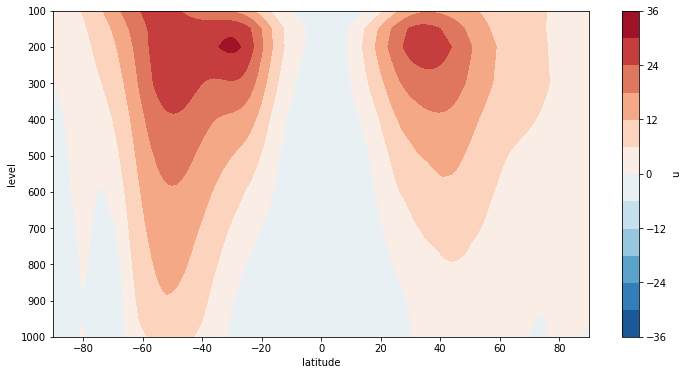

In [13]:
ds.u.mean(dim=['month', 'longitude']).plot.contourf(levels=13)
plt.ylim([1000, 100]);

### And other kind of things

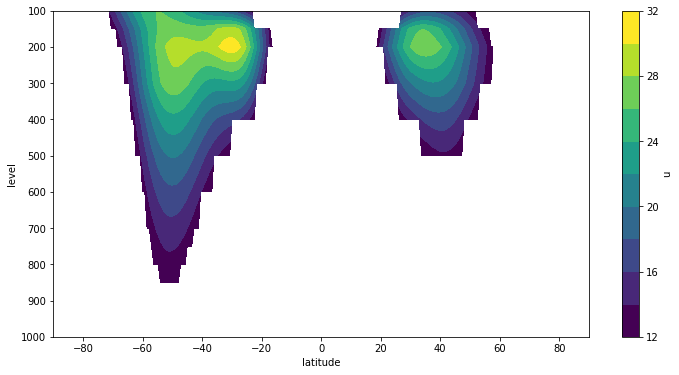

In [14]:
u_avg = ds.u.mean(dim=['month', 'longitude'])
u_avg_masked = u_avg.where(u_avg > 12)
u_avg_masked.plot.contourf(levels=13)
plt.ylim([1000, 100]);

# Arithmetic

### Broadcasting

<img src="./figures/broadcast.png" width="50%" align="left"> 

In [15]:
a = xr.DataArray(np.arange(3), dims='time', 
                 coords={'time':np.arange(3)})
b = xr.DataArray(np.arange(4), dims='space', 
                 coords={'space':np.arange(4)})
a + b

<xarray.DataArray (time: 3, space: 4)>
array([[0, 1, 2, 3],
       [1, 2, 3, 4],
       [2, 3, 4, 5]])
Coordinates:
  * time     (time) int64 0 1 2
  * space    (space) int64 0 1 2 3

### Alignment

<img src="./figures/align.png" width="50%" align="left"> 

In [16]:
a = xr.DataArray(np.arange(3), dims='time', 
                 coords={'time':np.arange(3)})
b = xr.DataArray(np.arange(5), dims='time', 
                 coords={'time':np.arange(5)+1})
a + b

<xarray.DataArray (time: 2)>
array([1, 3])
Coordinates:
  * time     (time) int64 1 2

# Plotting

### 1-d

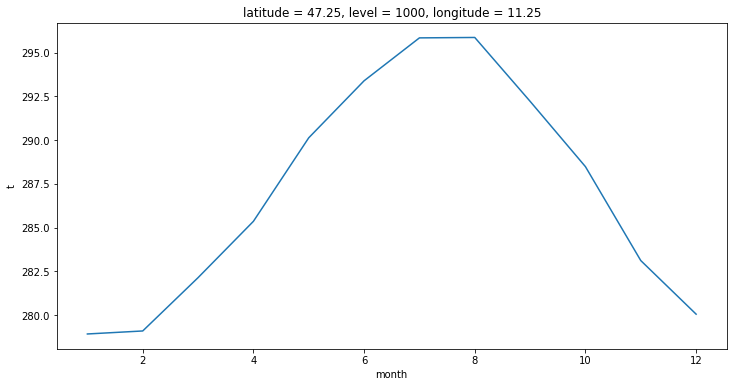

In [17]:
ts = ds.t.sel(level=1001, latitude=47.26, longitude=11.38, method='nearest')
ts.plot();

### On maps

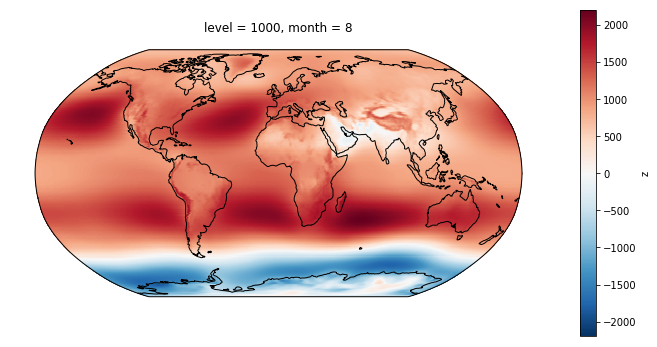

In [18]:
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.Robinson())
ds.z.sel(level=1000, month=8).plot(ax=ax, transform=ccrs.PlateCarree());
ax.coastlines();

# (Big) data: multiple files

Opening all files in a directory...

In [19]:
mfs = '/home/mowglie/disk/Data/Gridded/GPM/3BDAY_sorted/*.nc'
dsmf = xr.open_mfdataset(mfs)

... results in a consolidated dataset ...

In [20]:
dsmf

<xarray.Dataset>
Dimensions:           (lat: 732, lon: 620, time: 672)
Coordinates:
  * lat               (lat) float32 -56.95 -56.85 -56.75 ...
  * lon               (lon) float32 -93.55 -93.45 -93.35 ...
  * time              (time) datetime64[ns] 2014-03-31 ...
Data variables:
    precipitationCal  (time, lat, lon) float64 0.0 0.0 0.3 ...
    precipitationHQ   (time, lat, lon) float64 0.0 0.0 0.325 ...

... on which all usual operations can be applied:

In [21]:
dsmf = dsmf.sel(time='2015')
dsmf

<xarray.Dataset>
Dimensions:           (lat: 732, lon: 620, time: 365)
Coordinates:
  * lat               (lat) float32 -56.95 -56.85 -56.75 ...
  * lon               (lon) float32 -93.55 -93.45 -93.35 ...
  * time              (time) datetime64[ns] 2015-01-01 ...
Data variables:
    precipitationCal  (time, lat, lon) float64 0.0 0.0 0.0 ...
    precipitationHQ   (time, lat, lon) float64 0.0 0.0 0.0 ...

Yes, even computations!

In [22]:
ts = dsmf.precipitationCal.mean(dim=['lon', 'lat'])
ts

<xarray.DataArray 'precipitationCal' (time: 365)>
dask.array<mean_ag..., shape=(365,), dtype=float64, chunksize=(1,)>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ...

Computations are done "lazily" 

No actual computation has happened yet:

In [23]:
ts.data

dask.array<mean_ag..., shape=(365,), dtype=float64, chunksize=(1,)>

But they can be triggered:

In [24]:
ts = ts.load()
ts

<xarray.DataArray 'precipitationCal' (time: 365)>
array([ 2.297214,  3.00098 ,  2.532836, ...,  2.516468,
        2.334409,  3.469001])
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ...

For more information: http://xarray.pydata.org/en/stable/dask.html

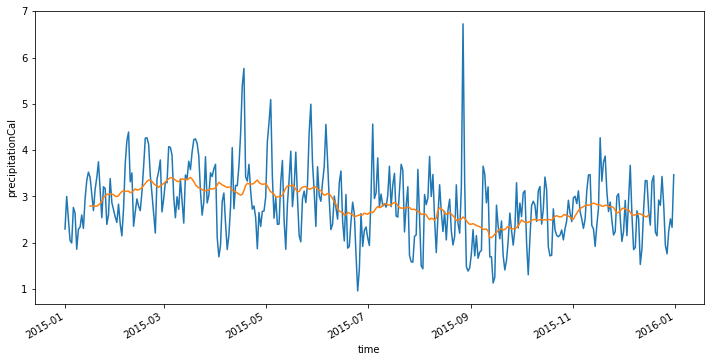

In [25]:
ts.plot();
ts.rolling(time=31, center=True).mean().plot();

# Extensions

### Example: EOFS 

Taken from: http://ajdawson.github.io/eofs/examples/nao_xarray.html

In [26]:
from eofs.xarray import Eof
from eofs.examples import example_data_path

# Read geopotential height data using the xarray module
filename = example_data_path('hgt_djf.nc')
z_djf = xr.open_dataset(filename)['z']

# Compute anomalies by removing the time-mean.
z_djf = z_djf - z_djf.mean(dim='time')

# Create an EOF solver to do the EOF analysis.
coslat = np.cos(np.deg2rad(z_djf.coords['latitude'].values)).clip(0., 1.)
solver = Eof(z_djf, weights=np.sqrt(coslat)[..., np.newaxis])

# Get the leading EOF
eof1 = solver.eofsAsCovariance(neofs=1)

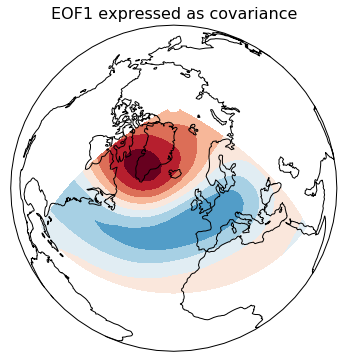

In [27]:
# Leading EOF expressed as covariance in the European/Atlantic domain
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-20, central_latitude=60))
ax.coastlines() ; ax.set_global()
eof1[0, 0].plot.contourf(ax=ax, levels=np.linspace(-75, 75, 11), 
                         cmap=plt.cm.RdBu_r, add_colorbar=False,
                         transform=ccrs.PlateCarree())
ax.set_title('EOF1 expressed as covariance', fontsize=16);

# Salem

- Adds geolocalized operations to xarray
- Adds WRF support

http://salem.readthedocs.io/en/latest/

Try it out:

```
pip install salem
```

## Plotting

In [28]:
# importing salem adds a new "toolbox" to xarray objects
import salem

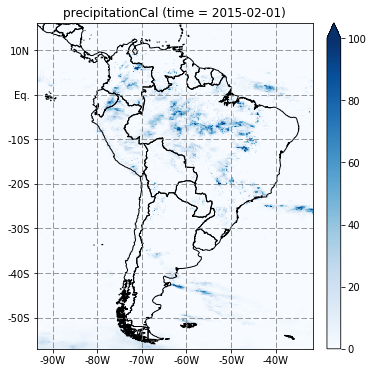

In [29]:
pday = dsmf.precipitationCal.sel(time='2015-02-01')
cm = pday.salem.quick_map(cmap='Blues', vmax=100);

## Subsetting

In [30]:
shdf = salem.read_shapefile(salem.get_demo_file('world_borders.shp'))
shdf = shdf.loc[shdf['CNTRY_NAME'].isin(['Peru'])]

In [31]:
dsmfperu = dsmf.salem.subset(shape=shdf, margin=10)

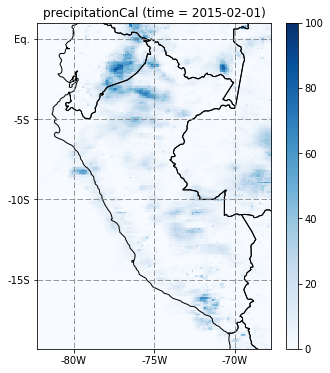

In [32]:
pday = dsmfperu.precipitationCal.sel(time='2015-02-01')
cm = pday.salem.quick_map(cmap='Blues', vmax=100);

## Regions of interest

In [33]:
dsmfperu = dsmfperu.salem.roi(shape=shdf)

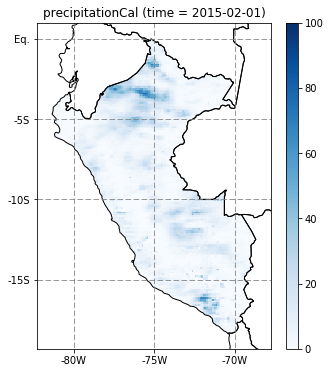

In [34]:
pday = dsmfperu.precipitationCal.sel(time='2015-02-01')
cm = pday.salem.quick_map(cmap='Blues', vmax=100);

## ... all xarray operations continue to apply

In [35]:
prpc_a = dsmfperu.precipitationCal.sum(dim=['time']).load()

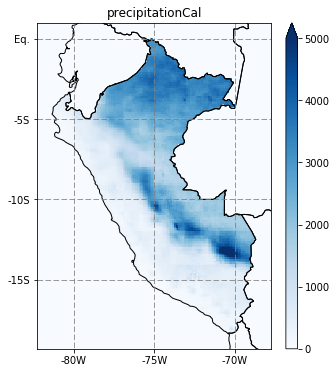

In [36]:
prpc_a.salem.quick_map(cmap='Blues', vmax=5000);

## WRF output files

Problems:
- not CF compliant (e.g. timestamp)
- staggered grids
- not all variables available (e.g. moisture transport)
- large

### Example file

In [37]:
f = 'wrfpost_d01_2005-09-21_00-00-00_25h.nc'

In [38]:
ds = xr.open_dataset(f)
ds

<xarray.Dataset>
Dimensions:              (Time: 9, bottom_top: 27, bottom_top_stag: 28, soil_layers_stag: 4, south_north: 200, south_north_stag: 201, west_east: 200, west_east_stag: 201)
Coordinates:
    XLAT                 (south_north, west_east) float32 1.62003 ...
    XLAT_U               (south_north, west_east_stag) float32 1.59409 ...
    XLAT_V               (south_north_stag, west_east) float32 1.50526 ...
    XLONG                (south_north, west_east) float32 63.3768 ...
    XLONG_U              (south_north, west_east_stag) float32 63.262 ...
    XLONG_V              (south_north_stag, west_east) float32 63.4026 ...
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, soil_layers_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times                (Time) |S19 b'2005-09-21_00:00:00' ...
    ACGRDFLX             (Time, south_north, west_east) float32 0.0 ...
    ACHFX                (Time, south_north, west_east) float32 17

### Objectives

- "clean" the file to make it more appealing
- automatic projection parsing
- automatic unstaggering
- pressure-levels interpolation
- diagnostic variables
- ...

In [39]:
wrf = salem.open_wrf_dataset(f)
wrf

<xarray.Dataset>
Dimensions:              (bottom_top: 27, soil_layers: 3, south_north: 200, time: 9, west_east: 200)
Coordinates:
    lat                  (south_north, west_east) float32 1.62003 ...
    lon                  (south_north, west_east) float32 63.3768 ...
  * time                 (time) datetime64[ns] 2005-09-21 ...
  * west_east            (west_east) float64 -2.985e+06 ...
  * south_north          (south_north) float64 -2.985e+06 ...
Dimensions without coordinates: bottom_top, soil_layers
Data variables:
    ACGRDFLX             (time, south_north, west_east) float32 0.0 ...
    ACHFX                (time, south_north, west_east) float32 173706.0 ...
    ACLHF                (time, south_north, west_east) float32 5.62606e+06 ...
    ALBBCK               (time, south_north, west_east) float32 0.08 ...
    ALBEDO               (time, south_north, west_east) float32 0.08 ...
    AVG_FUEL_FRAC        (time, south_north, west_east) float32 0.0 ...
    CANWAT               (

### Diagnostic variables

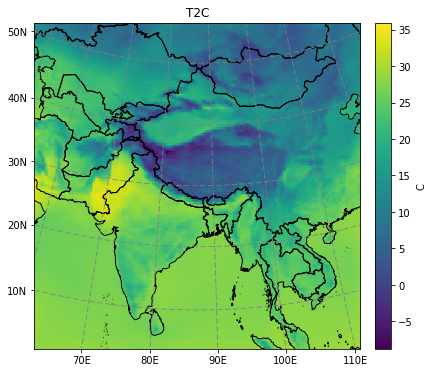

In [40]:
wrf.T2C.mean(dim='time', keep_attrs=True).salem.quick_map();

### 3D interpolation

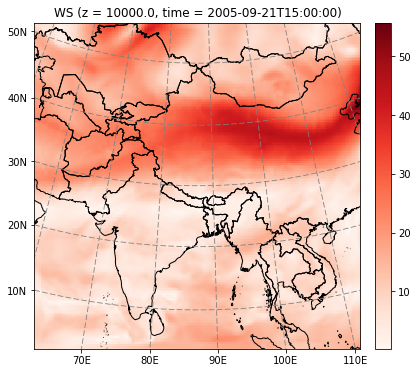

In [41]:
ws_h = wrf.isel(time=5).salem.wrf_zlevel('WS', levels=10000.)
ws_h.salem.quick_map(cmap='Reds');

### ... and more!

especially if I get some help ;-)

Repository: https://github.com/fmaussion/salem

# Final remarks

- xarray relies on pandas, which is one of the most widely used scientific python tools
- their documentation is excellent
- both libraries require a certain learning investment, but this time is well spent
- there is potential for "ACINN homegrown" tools based on these libs 